In [93]:
import sys
sys.path.append('..')

In [94]:
import pandas as pd
import numpy as np
import numpy.typing as npt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from src.pipeline import preprocessor

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [96]:
# Function to load and split the data
def load_data():
    df = pd.read_csv('../data/Tweets.csv')
    df = df.drop(columns=['tweet_id'])
    df_train, df_test = train_test_split(df, test_size=0.1, stratify=df[['airline_sentiment']], random_state=0)

    X_train = df_train.drop(columns=['airline_sentiment', 'airline_sentiment_confidence'])
    y_train = df_train[['airline_sentiment']]

    X_test = df_test.drop(columns=['airline_sentiment', 'airline_sentiment_confidence'])
    y_test = df_test[['airline_sentiment']]

    return X_train, y_train, X_test, y_test

In [97]:
# Load the data
X_train, y_train, X_test, y_test = load_data()

# Apply preprocessing to the training data
X_train_processed = torch.tensor(preprocessor.fit_transform(X_train).toarray(), dtype=torch.float32)
X_test_processed = torch.tensor(preprocessor.transform(X_test).toarray(), dtype=torch.float32)

In [98]:
# Encode target labels
ohe = OneHotEncoder(sparse_output=False)
y_train_ohe = torch.tensor(ohe.fit_transform(y_train), dtype=torch.float32)
y_test_ohe = torch.tensor(ohe.transform(y_test), dtype=torch.float32)

le = LabelEncoder()
y_train_labels = le.fit_transform(y_train.values.flatten())
y_test_labels = le.transform(y_test.values.flatten())

In [99]:
class FNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fnn = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, output_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float)
        x = self.fnn(x)
        return x

In [100]:
def fit_neural_network(
        model, optimizer, criterion,
        X: npt.NDArray, y: npt.NDArray, epochs: int, batch_size: int):
    
    n_batches = np.ceil(len(X) / batch_size).astype(np.int32)
    max_acc = 0.0
    for epoch in range(epochs):
        model.train()
        print(f"epoch {epoch+1}/{epochs}")
        permutation_idx = torch.randperm(X.size(0))
        X_shuffled = X[permutation_idx]
        y_shuffled = y[permutation_idx]

        running_loss = 0.0
        for i in range(0, X.size(0), batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        # print(f"average loss: {running_loss/n_batches}")

        model.eval()
        y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
        f1s = f1_score(y_test_labels, y_pred, average='weighted')
        acc = accuracy_score(y_test_labels, y_pred)
        print(f"f1: {f1s:.3f}\tacc: {acc:.3f}")
        if acc > max_acc:
            max_acc = acc
            torch.save(model, 'best_model.pt')

        running_loss = 0

In [101]:
model = FNN(X_train_processed.shape[1], 3)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [102]:
fit_neural_network(model, optimizer, criterion, X_train_processed, y_train_ohe, epochs=500, batch_size=128)

epoch 1/500
f1: 0.483	acc: 0.627
epoch 2/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.483	acc: 0.627
epoch 3/500
f1: 0.483	acc: 0.627
epoch 4/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.483	acc: 0.627
epoch 5/500
f1: 0.483	acc: 0.627
epoch 6/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.483	acc: 0.627
epoch 7/500
f1: 0.483	acc: 0.627
epoch 8/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.483	acc: 0.627
epoch 9/500
f1: 0.483	acc: 0.627
epoch 10/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.495	acc: 0.630
epoch 11/500
f1: 0.532	acc: 0.645
epoch 12/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.558	acc: 0.658
epoch 13/500
f1: 0.576	acc: 0.671
epoch 14/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.586	acc: 0.676
epoch 15/500
f1: 0.591	acc: 0.679
epoch 16/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.596	acc: 0.682
epoch 17/500
f1: 0.596	acc: 0.682
epoch 18/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.600	acc: 0.685
epoch 19/500
f1: 0.604	acc: 0.686
epoch 20/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.618	acc: 0.691
epoch 21/500
f1: 0.636	acc: 0.699
epoch 22/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.657	acc: 0.707
epoch 23/500
f1: 0.666	acc: 0.711
epoch 24/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.676	acc: 0.715
epoch 25/500
f1: 0.676	acc: 0.713
epoch 26/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.678	acc: 0.714
epoch 27/500
f1: 0.683	acc: 0.716
epoch 28/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.686	acc: 0.717
epoch 29/500
f1: 0.690	acc: 0.721
epoch 30/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.693	acc: 0.721
epoch 31/500
f1: 0.695	acc: 0.723
epoch 32/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.702	acc: 0.727
epoch 33/500
f1: 0.703	acc: 0.728
epoch 34/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.731
epoch 35/500
f1: 0.707	acc: 0.731
epoch 36/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.707	acc: 0.727
epoch 37/500
f1: 0.706	acc: 0.730
epoch 38/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.710	acc: 0.731
epoch 39/500
f1: 0.710	acc: 0.731
epoch 40/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.733
epoch 41/500
f1: 0.711	acc: 0.732
epoch 42/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.732
epoch 43/500
f1: 0.715	acc: 0.734
epoch 44/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.734
epoch 45/500
f1: 0.714	acc: 0.732
epoch 46/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.732
epoch 47/500
f1: 0.713	acc: 0.730
epoch 48/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.732
epoch 49/500
f1: 0.716	acc: 0.732
epoch 50/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.731
epoch 51/500
f1: 0.715	acc: 0.732
epoch 52/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.718	acc: 0.735
epoch 53/500
f1: 0.716	acc: 0.732
epoch 54/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.732
epoch 55/500
f1: 0.716	acc: 0.734
epoch 56/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.732
epoch 57/500
f1: 0.715	acc: 0.732
epoch 58/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.718	acc: 0.734
epoch 59/500
f1: 0.715	acc: 0.732
epoch 60/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.732
epoch 61/500
f1: 0.715	acc: 0.731
epoch 62/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.732
epoch 63/500
f1: 0.718	acc: 0.732
epoch 64/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.730
epoch 65/500
f1: 0.716	acc: 0.732
epoch 66/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.731
epoch 67/500
f1: 0.713	acc: 0.727
epoch 68/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.732
epoch 69/500
f1: 0.716	acc: 0.731
epoch 70/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.732
epoch 71/500
f1: 0.716	acc: 0.730
epoch 72/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.731
epoch 73/500
f1: 0.718	acc: 0.734
epoch 74/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.730
epoch 75/500
f1: 0.716	acc: 0.731
epoch 76/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.717	acc: 0.732
epoch 77/500
f1: 0.718	acc: 0.732
epoch 78/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.717	acc: 0.732
epoch 79/500
f1: 0.715	acc: 0.731
epoch 80/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.732
epoch 81/500
f1: 0.715	acc: 0.728
epoch 82/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.717	acc: 0.732
epoch 83/500
f1: 0.715	acc: 0.728
epoch 84/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.729
epoch 85/500
f1: 0.716	acc: 0.727
epoch 86/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.730
epoch 87/500
f1: 0.713	acc: 0.727
epoch 88/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.731
epoch 89/500
f1: 0.713	acc: 0.727
epoch 90/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.730
epoch 91/500
f1: 0.712	acc: 0.727
epoch 92/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.727
epoch 93/500
f1: 0.713	acc: 0.728
epoch 94/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.729
epoch 95/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.727
epoch 96/500
f1: 0.714	acc: 0.728
epoch 97/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.727
epoch 98/500
f1: 0.716	acc: 0.731
epoch 99/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.727
epoch 100/500
f1: 0.716	acc: 0.728
epoch 101/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.726
epoch 102/500
f1: 0.714	acc: 0.727
epoch 103/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.729
epoch 104/500
f1: 0.714	acc: 0.726
epoch 105/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.729
epoch 106/500
f1: 0.715	acc: 0.731
epoch 107/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.718	acc: 0.730
epoch 108/500
f1: 0.716	acc: 0.730
epoch 109/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.729
epoch 110/500
f1: 0.717	acc: 0.730
epoch 111/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.719	acc: 0.732
epoch 112/500
f1: 0.719	acc: 0.732
epoch 113/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.718	acc: 0.732
epoch 114/500
f1: 0.720	acc: 0.732
epoch 115/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.719	acc: 0.733
epoch 116/500
f1: 0.717	acc: 0.731
epoch 117/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.720	acc: 0.734
epoch 118/500
f1: 0.719	acc: 0.732
epoch 119/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.720	acc: 0.733
epoch 120/500
f1: 0.715	acc: 0.730
epoch 121/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.718	acc: 0.731
epoch 122/500
f1: 0.715	acc: 0.730
epoch 123/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.719	acc: 0.732
epoch 124/500
f1: 0.715	acc: 0.730
epoch 125/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.717	acc: 0.729
epoch 126/500
f1: 0.719	acc: 0.731
epoch 127/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.717	acc: 0.730
epoch 128/500
f1: 0.717	acc: 0.730
epoch 129/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.717	acc: 0.730
epoch 130/500
f1: 0.719	acc: 0.732
epoch 131/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.721	acc: 0.733
epoch 132/500
f1: 0.718	acc: 0.731
epoch 133/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.719	acc: 0.730
epoch 134/500
f1: 0.719	acc: 0.730
epoch 135/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.728
epoch 136/500
f1: 0.717	acc: 0.728
epoch 137/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.729
epoch 138/500
f1: 0.717	acc: 0.728
epoch 139/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.718	acc: 0.730
epoch 140/500
f1: 0.714	acc: 0.730
epoch 141/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.718	acc: 0.730
epoch 142/500
f1: 0.714	acc: 0.727
epoch 143/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.728
epoch 144/500
f1: 0.714	acc: 0.727
epoch 145/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.729
epoch 146/500
f1: 0.713	acc: 0.726
epoch 147/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.727
epoch 148/500
f1: 0.716	acc: 0.730
epoch 149/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.718	acc: 0.730
epoch 150/500
f1: 0.713	acc: 0.728
epoch 151/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.721	acc: 0.734
epoch 152/500
f1: 0.717	acc: 0.730
epoch 153/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.730
epoch 154/500
f1: 0.715	acc: 0.729
epoch 155/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.719	acc: 0.732
epoch 156/500
f1: 0.719	acc: 0.730
epoch 157/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.717	acc: 0.730
epoch 158/500
f1: 0.718	acc: 0.731
epoch 159/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.717	acc: 0.729
epoch 160/500
f1: 0.720	acc: 0.733
epoch 161/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.730
epoch 162/500
f1: 0.721	acc: 0.732
epoch 163/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.718	acc: 0.731
epoch 164/500
f1: 0.719	acc: 0.732
epoch 165/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.729
epoch 166/500
f1: 0.717	acc: 0.731
epoch 167/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.730
epoch 168/500
f1: 0.719	acc: 0.730
epoch 169/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.717	acc: 0.728
epoch 170/500
f1: 0.719	acc: 0.731
epoch 171/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.718	acc: 0.729
epoch 172/500
f1: 0.721	acc: 0.733
epoch 173/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.719	acc: 0.732
epoch 174/500
f1: 0.716	acc: 0.729
epoch 175/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.718	acc: 0.732
epoch 176/500
f1: 0.720	acc: 0.733
epoch 177/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.720	acc: 0.733
epoch 178/500
f1: 0.720	acc: 0.732
epoch 179/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.719	acc: 0.731
epoch 180/500
f1: 0.719	acc: 0.732
epoch 181/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.730
epoch 182/500
f1: 0.718	acc: 0.730
epoch 183/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.719	acc: 0.732
epoch 184/500
f1: 0.719	acc: 0.732
epoch 185/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.719	acc: 0.732
epoch 186/500
f1: 0.720	acc: 0.733
epoch 187/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.717	acc: 0.730
epoch 188/500
f1: 0.720	acc: 0.732
epoch 189/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.717	acc: 0.730
epoch 190/500
f1: 0.714	acc: 0.725
epoch 191/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.718	acc: 0.731
epoch 192/500
f1: 0.715	acc: 0.727
epoch 193/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.717	acc: 0.730
epoch 194/500
f1: 0.717	acc: 0.730
epoch 195/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.717	acc: 0.731
epoch 196/500
f1: 0.716	acc: 0.730
epoch 197/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.718	acc: 0.731
epoch 198/500
f1: 0.717	acc: 0.730
epoch 199/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.718	acc: 0.733
epoch 200/500
f1: 0.720	acc: 0.732
epoch 201/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.718	acc: 0.732
epoch 202/500
f1: 0.716	acc: 0.729
epoch 203/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.717	acc: 0.731
epoch 204/500
f1: 0.715	acc: 0.728
epoch 205/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.729
epoch 206/500
f1: 0.714	acc: 0.727
epoch 207/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.728
epoch 208/500
f1: 0.718	acc: 0.732
epoch 209/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.729
epoch 210/500
f1: 0.716	acc: 0.731
epoch 211/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.717	acc: 0.729
epoch 212/500
f1: 0.719	acc: 0.733
epoch 213/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.731
epoch 214/500
f1: 0.717	acc: 0.730
epoch 215/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.719	acc: 0.734
epoch 216/500
f1: 0.719	acc: 0.732
epoch 217/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.719	acc: 0.732
epoch 218/500
f1: 0.716	acc: 0.731
epoch 219/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.721	acc: 0.734
epoch 220/500
f1: 0.717	acc: 0.730
epoch 221/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.718	acc: 0.731
epoch 222/500
f1: 0.716	acc: 0.731
epoch 223/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.729
epoch 224/500
f1: 0.713	acc: 0.730
epoch 225/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.727
epoch 226/500
f1: 0.716	acc: 0.730
epoch 227/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.728
epoch 228/500
f1: 0.716	acc: 0.729
epoch 229/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.729
epoch 230/500
f1: 0.714	acc: 0.725
epoch 231/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.728
epoch 232/500
f1: 0.717	acc: 0.731
epoch 233/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.729
epoch 234/500
f1: 0.716	acc: 0.730
epoch 235/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.718	acc: 0.732
epoch 236/500
f1: 0.718	acc: 0.732
epoch 237/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.720	acc: 0.734
epoch 238/500
f1: 0.719	acc: 0.732
epoch 239/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.730
epoch 240/500
f1: 0.717	acc: 0.730
epoch 241/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.730
epoch 242/500
f1: 0.718	acc: 0.732
epoch 243/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.717	acc: 0.730
epoch 244/500
f1: 0.717	acc: 0.730
epoch 245/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.717	acc: 0.730
epoch 246/500
f1: 0.717	acc: 0.732
epoch 247/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.717	acc: 0.731
epoch 248/500
f1: 0.714	acc: 0.725
epoch 249/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.717	acc: 0.730
epoch 250/500
f1: 0.713	acc: 0.726
epoch 251/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.725
epoch 252/500
f1: 0.714	acc: 0.727
epoch 253/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.723
epoch 254/500
f1: 0.713	acc: 0.725
epoch 255/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.725
epoch 256/500
f1: 0.713	acc: 0.725
epoch 257/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.725
epoch 258/500
f1: 0.714	acc: 0.727
epoch 259/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.729
epoch 260/500
f1: 0.718	acc: 0.732
epoch 261/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.723
epoch 262/500
f1: 0.713	acc: 0.724
epoch 263/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.725
epoch 264/500
f1: 0.711	acc: 0.722
epoch 265/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.726
epoch 266/500
f1: 0.713	acc: 0.725
epoch 267/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.727
epoch 268/500
f1: 0.714	acc: 0.725
epoch 269/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.726
epoch 270/500
f1: 0.717	acc: 0.730
epoch 271/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.729
epoch 272/500
f1: 0.712	acc: 0.725
epoch 273/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.725
epoch 274/500
f1: 0.715	acc: 0.727
epoch 275/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.725
epoch 276/500
f1: 0.713	acc: 0.725
epoch 277/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.723
epoch 278/500
f1: 0.712	acc: 0.726
epoch 279/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.725
epoch 280/500
f1: 0.715	acc: 0.728
epoch 281/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.725
epoch 282/500
f1: 0.713	acc: 0.726
epoch 283/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.727
epoch 284/500
f1: 0.713	acc: 0.725
epoch 285/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.727
epoch 286/500
f1: 0.713	acc: 0.725
epoch 287/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.727
epoch 288/500
f1: 0.714	acc: 0.726
epoch 289/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.727
epoch 290/500
f1: 0.714	acc: 0.727
epoch 291/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.727
epoch 292/500
f1: 0.716	acc: 0.728
epoch 293/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.727
epoch 294/500
f1: 0.712	acc: 0.725
epoch 295/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.726
epoch 296/500
f1: 0.712	acc: 0.724
epoch 297/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.725
epoch 298/500
f1: 0.712	acc: 0.726
epoch 299/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.726
epoch 300/500
f1: 0.713	acc: 0.725
epoch 301/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.731
epoch 302/500
f1: 0.713	acc: 0.725
epoch 303/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.725
epoch 304/500
f1: 0.713	acc: 0.727
epoch 305/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.725
epoch 306/500
f1: 0.714	acc: 0.727
epoch 307/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.726
epoch 308/500
f1: 0.714	acc: 0.726
epoch 309/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.726
epoch 310/500
f1: 0.713	acc: 0.725
epoch 311/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.725
epoch 312/500
f1: 0.713	acc: 0.726
epoch 313/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.729
epoch 314/500
f1: 0.714	acc: 0.727
epoch 315/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.723
epoch 316/500
f1: 0.711	acc: 0.724
epoch 317/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.725
epoch 318/500
f1: 0.711	acc: 0.723
epoch 319/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.727
epoch 320/500
f1: 0.712	acc: 0.725
epoch 321/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.725
epoch 322/500
f1: 0.712	acc: 0.725
epoch 323/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.725
epoch 324/500
f1: 0.713	acc: 0.727
epoch 325/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.727
epoch 326/500
f1: 0.712	acc: 0.724
epoch 327/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.725
epoch 328/500
f1: 0.713	acc: 0.726
epoch 329/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.727
epoch 330/500
f1: 0.711	acc: 0.725
epoch 331/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.727
epoch 332/500
f1: 0.714	acc: 0.726
epoch 333/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.725
epoch 334/500
f1: 0.709	acc: 0.723
epoch 335/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.723
epoch 336/500
f1: 0.710	acc: 0.724
epoch 337/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.725
epoch 338/500
f1: 0.714	acc: 0.727
epoch 339/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.727
epoch 340/500
f1: 0.712	acc: 0.725
epoch 341/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.725
epoch 342/500
f1: 0.713	acc: 0.725
epoch 343/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.725
epoch 344/500
f1: 0.710	acc: 0.724
epoch 345/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.727
epoch 346/500
f1: 0.713	acc: 0.725
epoch 347/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.726
epoch 348/500
f1: 0.710	acc: 0.723
epoch 349/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.727
epoch 350/500
f1: 0.710	acc: 0.724
epoch 351/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.725
epoch 352/500
f1: 0.714	acc: 0.727
epoch 353/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.726
epoch 354/500
f1: 0.712	acc: 0.725
epoch 355/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.725
epoch 356/500
f1: 0.713	acc: 0.726
epoch 357/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.727
epoch 358/500
f1: 0.712	acc: 0.727
epoch 359/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.724
epoch 360/500
f1: 0.715	acc: 0.727
epoch 361/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.725
epoch 362/500
f1: 0.710	acc: 0.726
epoch 363/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.727
epoch 364/500
f1: 0.714	acc: 0.726
epoch 365/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.730
epoch 366/500
f1: 0.715	acc: 0.727
epoch 367/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.727
epoch 368/500
f1: 0.715	acc: 0.727
epoch 369/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.716	acc: 0.727
epoch 370/500
f1: 0.709	acc: 0.723
epoch 371/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.725
epoch 372/500
f1: 0.711	acc: 0.724
epoch 373/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.726
epoch 374/500
f1: 0.713	acc: 0.725
epoch 375/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.727
epoch 376/500
f1: 0.709	acc: 0.724
epoch 377/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.726
epoch 378/500
f1: 0.712	acc: 0.724
epoch 379/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.729
epoch 380/500
f1: 0.712	acc: 0.725
epoch 381/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.727
epoch 382/500
f1: 0.710	acc: 0.723
epoch 383/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.725
epoch 384/500
f1: 0.716	acc: 0.729
epoch 385/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.726
epoch 386/500
f1: 0.712	acc: 0.725
epoch 387/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.710	acc: 0.725
epoch 388/500
f1: 0.712	acc: 0.725
epoch 389/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.725
epoch 390/500
f1: 0.712	acc: 0.726
epoch 391/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.727
epoch 392/500
f1: 0.712	acc: 0.727
epoch 393/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.728
epoch 394/500
f1: 0.713	acc: 0.728
epoch 395/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.727
epoch 396/500
f1: 0.711	acc: 0.724
epoch 397/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.715	acc: 0.729
epoch 398/500
f1: 0.713	acc: 0.727
epoch 399/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.728
epoch 400/500
f1: 0.711	acc: 0.726
epoch 401/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.725
epoch 402/500
f1: 0.710	acc: 0.725
epoch 403/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.721
epoch 404/500
f1: 0.709	acc: 0.723
epoch 405/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.723
epoch 406/500
f1: 0.712	acc: 0.726
epoch 407/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.723
epoch 408/500
f1: 0.709	acc: 0.725
epoch 409/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.725
epoch 410/500
f1: 0.710	acc: 0.723
epoch 411/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.724
epoch 412/500
f1: 0.709	acc: 0.723
epoch 413/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.707	acc: 0.721
epoch 414/500
f1: 0.709	acc: 0.724
epoch 415/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.727
epoch 416/500
f1: 0.713	acc: 0.725
epoch 417/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.726
epoch 418/500
f1: 0.710	acc: 0.724
epoch 419/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.725
epoch 420/500
f1: 0.711	acc: 0.724
epoch 421/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.723
epoch 422/500
f1: 0.709	acc: 0.723
epoch 423/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.727
epoch 424/500
f1: 0.709	acc: 0.721
epoch 425/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.724
epoch 426/500
f1: 0.710	acc: 0.723
epoch 427/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.725
epoch 428/500
f1: 0.712	acc: 0.725
epoch 429/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.723
epoch 430/500
f1: 0.708	acc: 0.724
epoch 431/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.723
epoch 432/500
f1: 0.711	acc: 0.726
epoch 433/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.726
epoch 434/500
f1: 0.709	acc: 0.722
epoch 435/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.723
epoch 436/500
f1: 0.714	acc: 0.727
epoch 437/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.713	acc: 0.726
epoch 438/500
f1: 0.709	acc: 0.723
epoch 439/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.725
epoch 440/500
f1: 0.710	acc: 0.725
epoch 441/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.723
epoch 442/500
f1: 0.711	acc: 0.723
epoch 443/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.710	acc: 0.725
epoch 444/500
f1: 0.711	acc: 0.725
epoch 445/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.723
epoch 446/500
f1: 0.712	acc: 0.725
epoch 447/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.710	acc: 0.724
epoch 448/500
f1: 0.708	acc: 0.723
epoch 449/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.723
epoch 450/500
f1: 0.705	acc: 0.722
epoch 451/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.707	acc: 0.721
epoch 452/500
f1: 0.707	acc: 0.721
epoch 453/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.723
epoch 454/500
f1: 0.706	acc: 0.721
epoch 455/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.707	acc: 0.721
epoch 456/500
f1: 0.707	acc: 0.720
epoch 457/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.706	acc: 0.720
epoch 458/500
f1: 0.709	acc: 0.723
epoch 459/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.721
epoch 460/500
f1: 0.706	acc: 0.721
epoch 461/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.707	acc: 0.721
epoch 462/500
f1: 0.708	acc: 0.720
epoch 463/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.721
epoch 464/500
f1: 0.708	acc: 0.723
epoch 465/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.714	acc: 0.726
epoch 466/500
f1: 0.710	acc: 0.723
epoch 467/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.712	acc: 0.724
epoch 468/500
f1: 0.707	acc: 0.721
epoch 469/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.723
epoch 470/500
f1: 0.711	acc: 0.724
epoch 471/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.711	acc: 0.723
epoch 472/500
f1: 0.709	acc: 0.723
epoch 473/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.707	acc: 0.722
epoch 474/500
f1: 0.709	acc: 0.723
epoch 475/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.705	acc: 0.721
epoch 476/500
f1: 0.706	acc: 0.720
epoch 477/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.722
epoch 478/500
f1: 0.707	acc: 0.721
epoch 479/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.706	acc: 0.720
epoch 480/500
f1: 0.708	acc: 0.722
epoch 481/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.704	acc: 0.718
epoch 482/500
f1: 0.706	acc: 0.719
epoch 483/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.707	acc: 0.722
epoch 484/500
f1: 0.707	acc: 0.721
epoch 485/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.723
epoch 486/500
f1: 0.708	acc: 0.721
epoch 487/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.709	acc: 0.721
epoch 488/500
f1: 0.708	acc: 0.721
epoch 489/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.707	acc: 0.721
epoch 490/500
f1: 0.708	acc: 0.721
epoch 491/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.706	acc: 0.720
epoch 492/500
f1: 0.707	acc: 0.720
epoch 493/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.704	acc: 0.718
epoch 494/500
f1: 0.704	acc: 0.717
epoch 495/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.707	acc: 0.721
epoch 496/500
f1: 0.708	acc: 0.721
epoch 497/500


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


f1: 0.708	acc: 0.721
epoch 498/500
f1: 0.709	acc: 0.722
epoch 499/500
f1: 0.710	acc: 0.722
epoch 500/500
f1: 0.707	acc: 0.721


C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
C:\temp\ipykernel_4600\3292427394.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))


In [ ]:
model = torch.load("best_model.pt", weights_only=False)
model.eval()



y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))



accuracy_score(y_test_labels, y_pred)



f1_score(y_test_labels, y_pred, average='weighted')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1464x221 and 232x64)

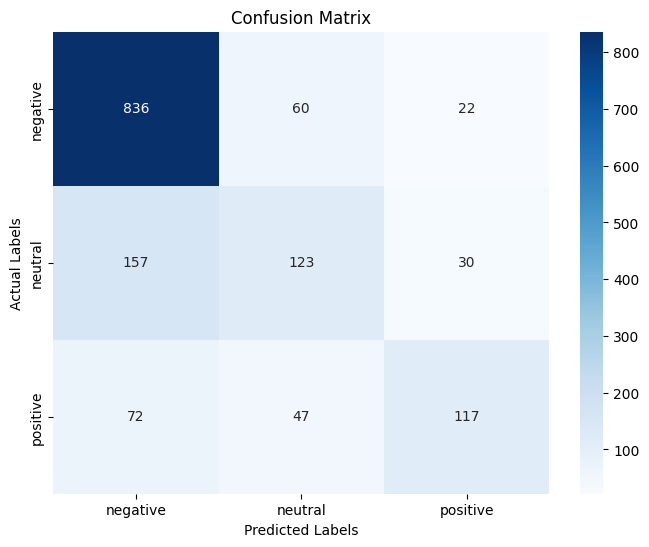

In [125]:
# Generating a confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

# Visualizing the confusion matrix using seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

C:\temp\ipykernel_4600\472587763.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_train_pred = np.array(torch.argmax(y_train_pred, dim=1))


Accuracy on training data: 0.8404
Accuracy on test data: 0.7206

Classification report for the test data:
              precision    recall  f1-score   support

    negative       0.78      0.89      0.83       918
     neutral       0.51      0.42      0.46       310
    positive       0.69      0.47      0.56       236

    accuracy                           0.72      1464
   macro avg       0.66      0.59      0.62      1464
weighted avg       0.71      0.72      0.71      1464



C:\temp\ipykernel_4600\472587763.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_test_pred = np.array(torch.argmax(y_test_pred, dim=1))


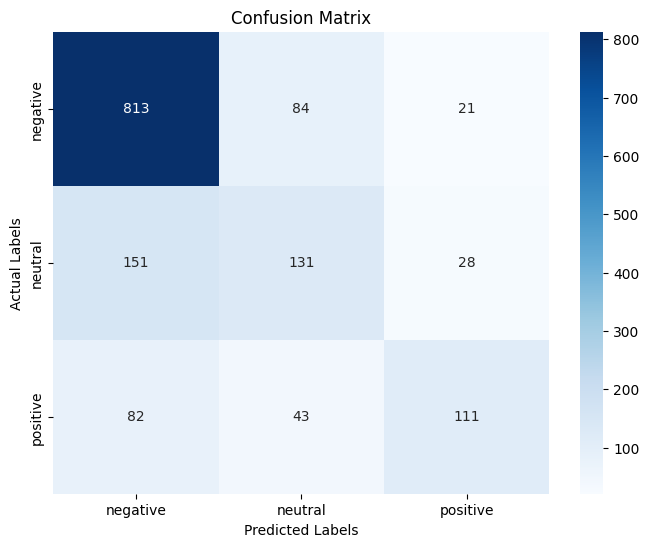

In [105]:
# Predicting on the training data
y_train_pred = model(X_train_processed)
y_train_pred = np.array(torch.argmax(y_train_pred, dim=1))

# Calculating accuracy on the training data
train_accuracy = accuracy_score(y_train_labels, y_train_pred)
print(f"Accuracy on training data: {train_accuracy:.4f}")

# Predicting on the test data
y_test_pred = model(X_test_processed)
y_test_pred = np.array(torch.argmax(y_test_pred, dim=1))

# Calculating accuracy on the test data
test_accuracy = accuracy_score(y_test_labels, y_test_pred)
print(f"Accuracy on test data: {test_accuracy:.4f}")

# Generating a classification report
print("\nClassification report for the test data:")
print(classification_report(y_test_labels, y_test_pred, target_names=le.classes_))

# Generating a confusion matrix
cm = confusion_matrix(y_test_labels, y_test_pred)

# Visualizing the confusion matrix using seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

# # Calculating AUC for multi-class classification
# y_test_prob = clf.predict_proba(X_test_processed)

# auc = roc_auc_score(y_test_processed, y_test_prob, multi_class='ovr')
# print(f"AUC (One-vs-Rest) on test data: {auc:.4f}")


# Area under the curve (AUC)

In [106]:
model.eval()

with torch.no_grad():
    y_pred_probs = model(X_test_processed) 

y_pred_probs = y_pred_probs.cpu().numpy()  

In [107]:
from sklearn.preprocessing import label_binarize

num_classes = 3
y_test_onehot = label_binarize(y_test_labels, classes=[0, 1, 2])  

In [108]:
from sklearn.metrics import roc_auc_score

auc_ovr_weighted = roc_auc_score(y_test_onehot, y_pred_probs, multi_class="ovr", average="weighted")
print("Weighted One-vs-Rest AUC:", auc_ovr_weighted)

Weighted One-vs-Rest AUC: 0.8198321971068591


# Gini Coefficient

In [109]:
gini_ovr_weighted = 2 * auc_ovr_weighted - 1
print("Weighted One-vs-Rest Gini:", gini_ovr_weighted)

Weighted One-vs-Rest Gini: 0.6396643942137181


In [110]:
auc_per_class = roc_auc_score(y_test_onehot, y_pred_probs, multi_class="ovr", average=None)

gini_per_class = 2 * auc_per_class - 1

for i, (auc_val, gini_val) in enumerate(zip(auc_per_class, gini_per_class)):
    print(f"Class {i}: AUC={auc_val:.3f}, Gini={gini_val:.3f}")

Class 0: AUC=0.823, Gini=0.646
Class 1: AUC=0.779, Gini=0.558
Class 2: AUC=0.860, Gini=0.721
